## Import libraries

In [2]:
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Polygon
import folium
import pandas as pd

## Set bounding box for the area

In [3]:
max_x = -78.6
min_x = -78.65
max_y = 35.8
min_y = 35.75

bbox = Polygon([[max_x, max_y],[min_x, max_y], [min_x, min_y],[max_x, min_y]])

## Import files 

In [4]:
buildings = gpd.read_file("./data/Building_Footprints.geojson")
evse = gpd.read_file("./data/EVSE_Stations.geojson")
bus_stops = gpd.read_file("./data/GoRaleigh_Bus_Stops.geojson")
police_incidents = gpd.read_file("./data/Raleigh_Police_Incidents_(SRS).geojson")

### Select features in bounding box area

In [5]:
buildings = buildings[(buildings.geometry.centroid.x<max_x)&(buildings.geometry.centroid.x>min_x)&(buildings.geometry.centroid.y<max_y)&(buildings.geometry.centroid.y>min_y)]
evse = evse[(evse.geometry.centroid.x<max_x)&(evse.geometry.centroid.x>min_x)&(evse.geometry.centroid.y<max_y)&(evse.geometry.centroid.y>min_y)]
bus_stops = bus_stops[(bus_stops.geometry.centroid.x<max_x)&(bus_stops.geometry.centroid.x>min_x)&(bus_stops.geometry.centroid.y<max_y)&(bus_stops.geometry.centroid.y>min_y)]
police_incidents = police_incidents[(police_incidents.geometry.centroid.x<max_x)&(police_incidents.geometry.centroid.x>min_x)&(police_incidents.geometry.centroid.y<max_y)&(police_incidents.geometry.centroid.y>min_y)]

/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/1495256417.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings = buildings[(buildings.geometry.centroid.x<max_x)&(buildings.geometry.centroid.x>min_x)&(buildings.geometry.centroid.y<max_y)&(buildings.geometry.centroid.y>min_y)]
/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/1495256417.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  evse = evse[(evse.geometry.centroid.x<max_x)&(evse.geometry.centroid.x>min_x)&(evse.geometry.centroid.y<max_y)&(evse.geometry.centroid.y>min_y)]
/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/1495256417.py:3: UserWarning: Geometry is in a geographic CRS. Results from '

In [7]:
counties = gpd.read_file('data/tl_2023_us_county/')

In [8]:
counties = counties.to_crs("EPSG:4326")

In [9]:
raleigh_counties = counties[counties['NAME'].isin(['Wake'])]

In [10]:
raleigh_counties

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
2373,37,183,01008592,37183,0500000US37183,Wake,Wake County,06,H1,G4020,450,39580,None,A,2161632139,58019078,+35.7898464,-078.6506240,"POLYGON ((-78.69436 35.53008, -78.69456 35.529..."


In [11]:
raleigh_counties.geometry

2373    POLYGON ((-78.69436 35.53008, -78.69456 35.529...
Name: geometry, dtype: geometry

## Read data from OSMNX to NeworkX graph

In [12]:
roads_raleigh = ox.graph_from_polygon(raleigh_counties.geometry.unary_union, simplify=True)
roads_bbox = ox.graph_from_polygon(bbox, simplify=True)

### Convert to GeoDataFrame

In [13]:
roads_gdf = ox.graph_to_gdfs(roads_raleigh, nodes=False)
bbox_gdf = ox.graph_to_gdfs(roads_bbox, nodes=False)

Sort by centroids

In [14]:
roads_gdf['x'] = roads_gdf.geometry.centroid.x
roads_gdf['y'] = roads_gdf.geometry.centroid.y

roads_gdf.sort_values(['x', 'y'], inplace=True)

/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/3254054143.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roads_gdf['x'] = roads_gdf.geometry.centroid.x
/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/3254054143.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roads_gdf['y'] = roads_gdf.geometry.centroid.y


Add centroid columns

In [15]:
buildings['x'] = buildings.geometry.centroid.x
buildings['y'] = buildings.geometry.centroid.y

/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/1337570149.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings['x'] = buildings.geometry.centroid.x
/var/folders/w1/ff_wljvx5r19b2k_gvbz9shr0000gn/T/ipykernel_15435/1337570149.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  buildings['y'] = buildings.geometry.centroid.y


In [16]:
bs_temp = bus_stops['geometry']
build_temp = buildings['geometry']

In [17]:
m = bbox_gdf.explore()
m = evse.explore(m=m, color="red")
m = build_temp.explore(m=m, color="green")
#m = police_incidents.explore(m=m, color="yellow")
m = bs_temp.explore(m=m, color="black")
# this is completely optional
folium.LayerControl().add_to(m)

In [93]:
bbox_gdf.to_csv('osm_bbox_raleigh.csv')

In [94]:
evse.to_csv('evse_bbox_raleigh.csv')

In [96]:
buildings.to_csv('build_bbox_raleigh.csv')

In [ ]:
build_temp.to_csv('build_bbox_raleigh.csv')

# Distance to EV stations

### Spatial Join to get distance between building and ev charging station

In [22]:
buildings = buildings.to_crs("EPSG:32632").sjoin_nearest(evse.to_crs("EPSG:32632"), how='left', distance_col='distance_to_ev')

In [30]:
buildings = buildings.to_crs("EPSG:4326")

In [31]:
buildings.drop("index_right", axis=1, inplace=True)

In [32]:
build_com = buildings[buildings['DESCRIPTION']=='COMMERCIAL']
build_rest = buildings[buildings['DESCRIPTION']!='COMMERCIAL']

### Buffer commerial and get the count of residential buildings within 1000 meter buffer

In [33]:
build_com['geometry'] = build_com.to_crs("EPSG:32632").geometry.buffer(1000)
c_joined_r = build_com.sjoin(build_rest.to_crs("EPSG:32632"), how='left')

/opt/anaconda3/envs/python-env/lib/python3.12/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  "Geometry column does not contain geometry.",


### Get the average distance to ev of all residential properties in 1000m buffer

In [34]:
agg_c = c_joined_r.groupby("OBJECTID_left").agg({"OBJECTID_right":"count", "distance_to_ev_right":"mean"})

In [35]:
agg_c

,OBJECTID_right,distance_to_ev_right
OBJECTID_left,,
5404,264,1671.851062
5426,264,1684.929185
9095,64,1148.112972
9098,68,1114.692623
9100,68,1114.692623
...,...,...
177697,1049,3808.995612
177698,619,2707.139608
177699,1298,3699.653848


In [36]:
agg_c.rename({"OBJECTID_right":"num_residential_1000", "distance_to_ev_right":"avg_dis_to_res_ev"}, axis=1, inplace=True)

In [37]:
agg_c.reset_index(inplace=True)
agg_c.rename({"OBJECTID_left":"OBJECTID"}, axis=1, inplace=True)

In [38]:
agg_c

,OBJECTID,num_residential_1000,avg_dis_to_res_ev
0,5404,264,1671.851062
1,5426,264,1684.929185
2,9095,64,1148.112972
3,9098,68,1114.692623
4,9100,68,1114.692623
...,...,...,...
1537,177697,1049,3808.995612
1538,177698,619,2707.139608
1539,177699,1298,3699.653848
1540,177700,1076,3777.050386


In [39]:
buildings = buildings.merge(agg_c, on='OBJECTID', how='left')

In [40]:
buildings.to_csv("build_bbox_raleigh.csv")

<Axes: xlabel='avg_dis_to_res_ev', ylabel='num_residential_1000'>

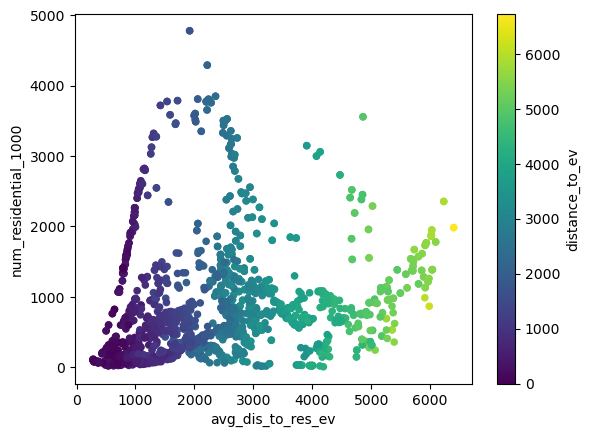

In [41]:
pd.DataFrame(buildings).plot.scatter(x='avg_dis_to_res_ev', y='num_residential_1000', c='distance_to_ev')

<Axes: xlabel='distance_to_ev', ylabel='avg_dis_to_res_ev'>

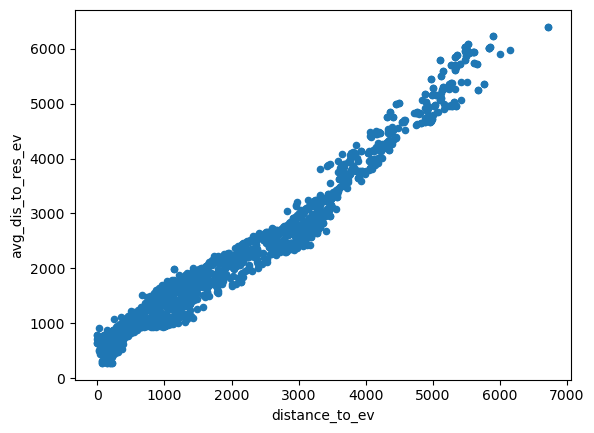

In [42]:
pd.DataFrame(buildings).plot.scatter(x='distance_to_ev', y='avg_dis_to_res_ev')

In [48]:
# Scaling the num_residential_1000
buildings['num_residential_1000_scaled']=(buildings['num_residential_1000']-buildings['num_residential_1000'].min())/(buildings['num_residential_1000'].max()-buildings['num_residential_1000'].min())

#Scaling the avg_dis_to_res_ev
buildings['avg_dis_to_res_ev_scaled']=(buildings['avg_dis_to_res_ev']-buildings['avg_dis_to_res_ev'].min())/(buildings['avg_dis_to_res_ev'].max()-buildings['avg_dis_to_res_ev'].min())


In [49]:
#Euclidean distance (or L2 norm) of the scaled values in a 2D space

buildings['buildings_ev_index'] = (buildings['num_residential_1000_scaled']**2+buildings['avg_dis_to_res_ev_scaled']**2)**0.5

In [45]:
buildings['buildings_ev_index_2'] = buildings['num_residential_1000_scaled']*buildings['avg_dis_to_res_ev_scaled']

<Axes: xlabel='avg_dis_to_res_ev', ylabel='num_residential_1000'>

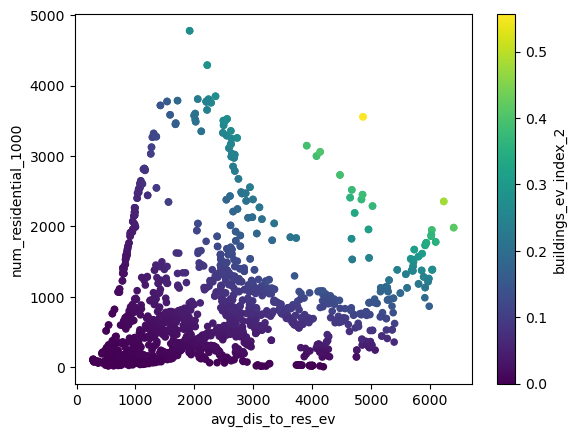

In [46]:
pd.DataFrame(buildings).plot.scatter(x='avg_dis_to_res_ev', y='num_residential_1000', c='buildings_ev_index_2')